In [32]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis
from sbi.inference.base import infer
import corner

In [33]:
GNN_preds = np.load("../outs/20230720_GATv2/preds.npy")
prim_preds = np.load("../outs/20230720_past/preds.npy")
GNN_labels = np.load("../outs/20230720_GATv2/true.npy")
prim_labels = np.load("../outs/20230720_past/true.npy")

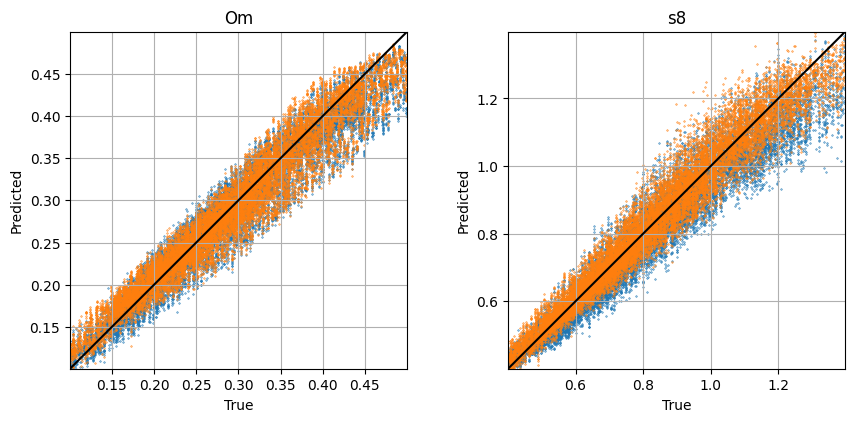

In [35]:
labels = ["Om", "s8"]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
# add hspace and vspace
fig.subplots_adjust(wspace=0.3, hspace=0.2)
for i, ax in enumerate(axs.flatten()):
    ax.scatter(GNN_labels[:, i], GNN_preds[:, i], marker="x", alpha=0.5, s=1)
    ax.scatter(prim_labels[:, i], prim_preds[:, i], marker="x", alpha=0.5, s=1)
    ax.plot([np.min(prim_labels[:, i]), np.max(prim_labels[:, i])], \
                        [np.min(prim_labels[:, i]), np.max(prim_labels[:, i])], c="k")
    ax.set_xlim([np.min(prim_labels[:, i]), np.max(prim_labels[:, i])])
    ax.set_ylim([np.min(prim_labels[:, i]), np.max(prim_labels[:, i])])
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.set_aspect("equal")
    ax.set_title(labels[i])
    ax.grid()
plt.show()
plt.close()

In [37]:
prior = utils.BoxUniform(low=np.min(prim_labels, axis=0), high=np.max(prim_labels, axis=0))
proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='maf',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(prim_labels), torch.FloatTensor(prim_preds)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior_prim = inference.build_posterior(density_estimator)

proposal = prior
inference = SNPE(prior=prior, density_estimator=utils.posterior_nn(model='maf',
                                                hidden_features=50,
                                                num_transforms=4))

theta, x = torch.FloatTensor(GNN_labels), torch.FloatTensor(GNN_preds)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior_GNN = inference.build_posterior(density_estimator)

 Neural network successfully converged after 113 epochs.

In [46]:
ind = np.random.randint(0, len(prim_labels))
x_0 = prim_labels[ind]
print(ind, x_0)

2213 [0.45849609 0.66391599]


In [47]:
posterior_samples_prim = posterior_prim.set_default_x(x_0).sample((10000,), x=x_0)
posterior_samples_GNN = posterior_GNN.set_default_x(x_0).sample((10000,), x=x_0)

Drawing 10000 posterior samples: 10479it [00:00, 108663.52it/s]           
Drawing 10000 posterior samples: 10381it [00:00, 225569.84it/s]           


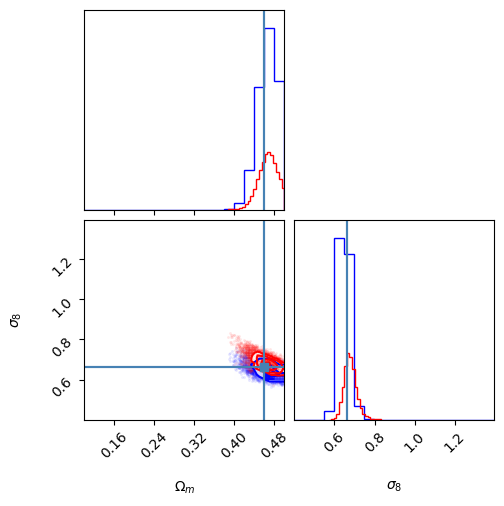

In [48]:
fig = corner.corner(np.array(posterior_samples_prim), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(prim_labels, axis=0), np.max(prim_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_GNN), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

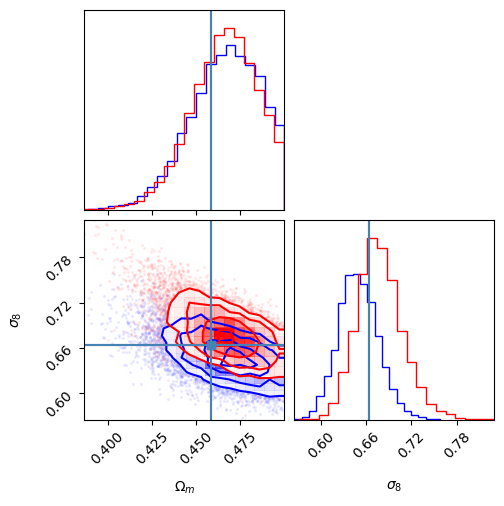

In [49]:
fig = corner.corner(np.array(posterior_samples_prim), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_GNN), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

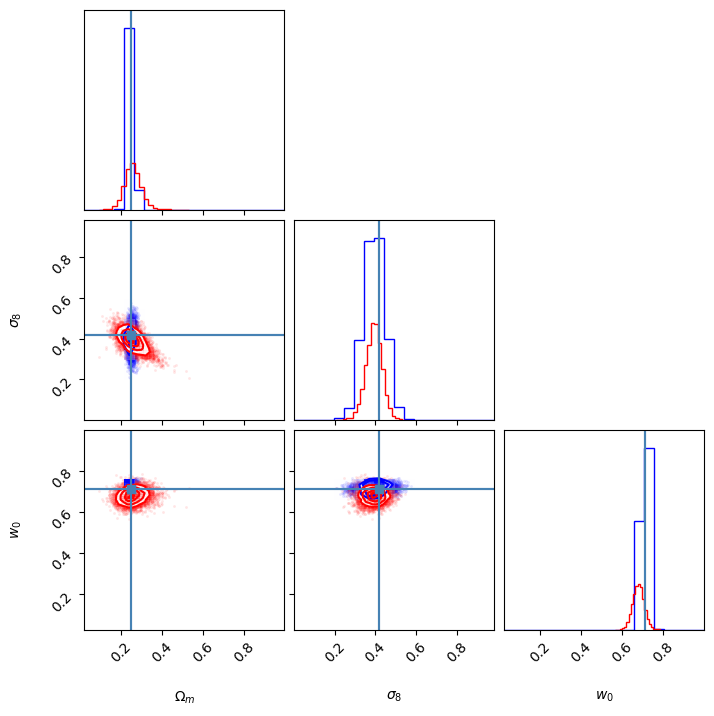

In [ ]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue", range=np.array([np.min(vit_labels, axis=0), np.max(vit_labels, axis=0)]).T)
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")

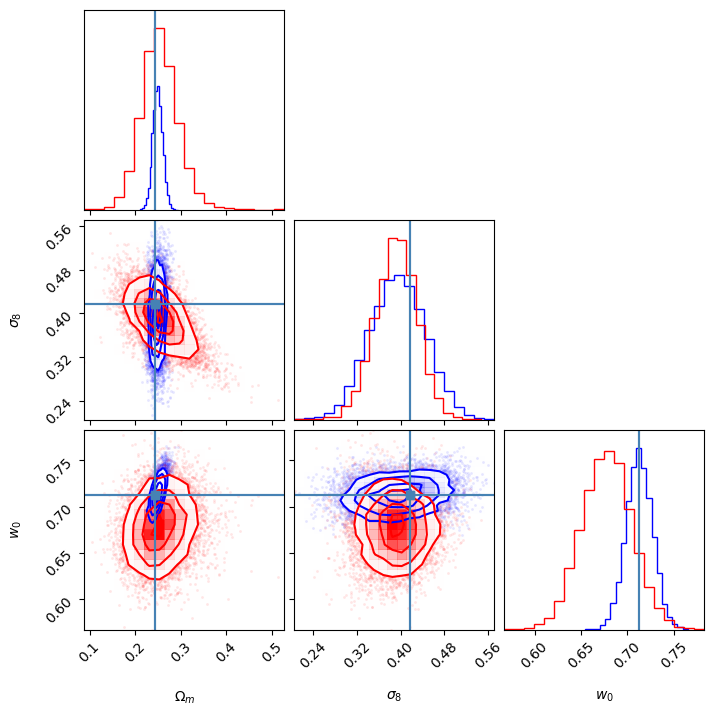

In [ ]:
fig = corner.corner(np.array(posterior_samples_vit), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    color="blue")
fig = corner.corner(np.array(posterior_samples_resnet), truths=x_0, labels=[r"$\Omega_m$", r"$\sigma_8$", r"$w_0$"],
                    fig=fig, color="red")